# VQ-VAE

In [2]:
from model import VQVAE

import tensorflow as tf
import keras as K
import numpy as np
import os

import matplotlib.pyplot as plt

### Data Preprocessing

In [ ]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
mnist_digits_train = tf.cast(x_train, tf.float64) / 255.0
mnist_digits_train = np.expand_dims(mnist_digits_train, -1)
mnist_digits_test = tf.cast(x_test, tf.float64) / 255.0
mnist_digits_test = np.expand_dims(mnist_digits_test, -1)

train_variance = np.var(x_train / 255.0) # Normalizar 

### Training the VAE

In [5]:
vqvae = VQVAE(image_size=28, channels=1, latent_dim=16, train_variance=train_variance, num_embeddings=128, beta=0.5)
vqvae.compile(optimizer=K.optimizers.Adam())
callbacks = vqvae.get_callbacks(log_dir="logs", patience=10)
vqvae.fit(mnist_digits_train, epochs=50, batch_size=256, callbacks=callbacks)

Epoch 1/50


I0000 00:00:1759028128.779442   14867 service.cc:148] XLA service 0x7933fc00d3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759028128.779514   14867 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2025-09-28 02:55:28.837620: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759028129.026083   14867 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/235 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4170 - reconstruction_loss: 2.4160 - vqvae_loss: 9.9393e-04  

I0000 00:00:1759028130.761075   14867 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 59.8371 - reconstruction_loss: 0.6494 - vqvae_loss: 59.1877
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 159.8950 - reconstruction_loss: 0.1703 - vqvae_loss: 159.7247
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 162.4843 - reconstruction_loss: 0.1376 - vqvae_loss: 162.3468
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 169.1288 - reconstruction_loss: 0.1220 - vqvae_loss: 169.0068
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 149.9207 - reconstruction_loss: 0.1079 - vqvae_loss: 149.8129
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 146.6827 - reconstruction_loss: 0.1012 - vqvae_loss: 146.5816
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 142.3495 - reconstruction_loss: 0.0955 - vqvae_loss: 142.2540
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 140.5836 - reconstruction_loss: 0.0909 - vqvae_loss: 140.4927
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━

In [6]:
for metric in vqvae.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 137.56980895996094
reconstruction_loss: 0.08319584280252457
vq_loss: 137.48666381835938


Esto da diferente estoy usando un device M3 (a través de Metal Performance Shaders) que en tiene un comportamiento numérico diferente a CUDA. De hecho tuve usar un clip en el kl_loss para evitar explosiones numéricas.

In [7]:
# Save
os.makedirs("./weights", exist_ok=True)
vqvae.save("./weights/vqvae.keras")

/root/VAE-VQ-VAE/.venv/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [8]:
# Load
# vqvae = K.models.load_model("./weights/vqvae.keras") # WIP: Fix needed    

### View Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


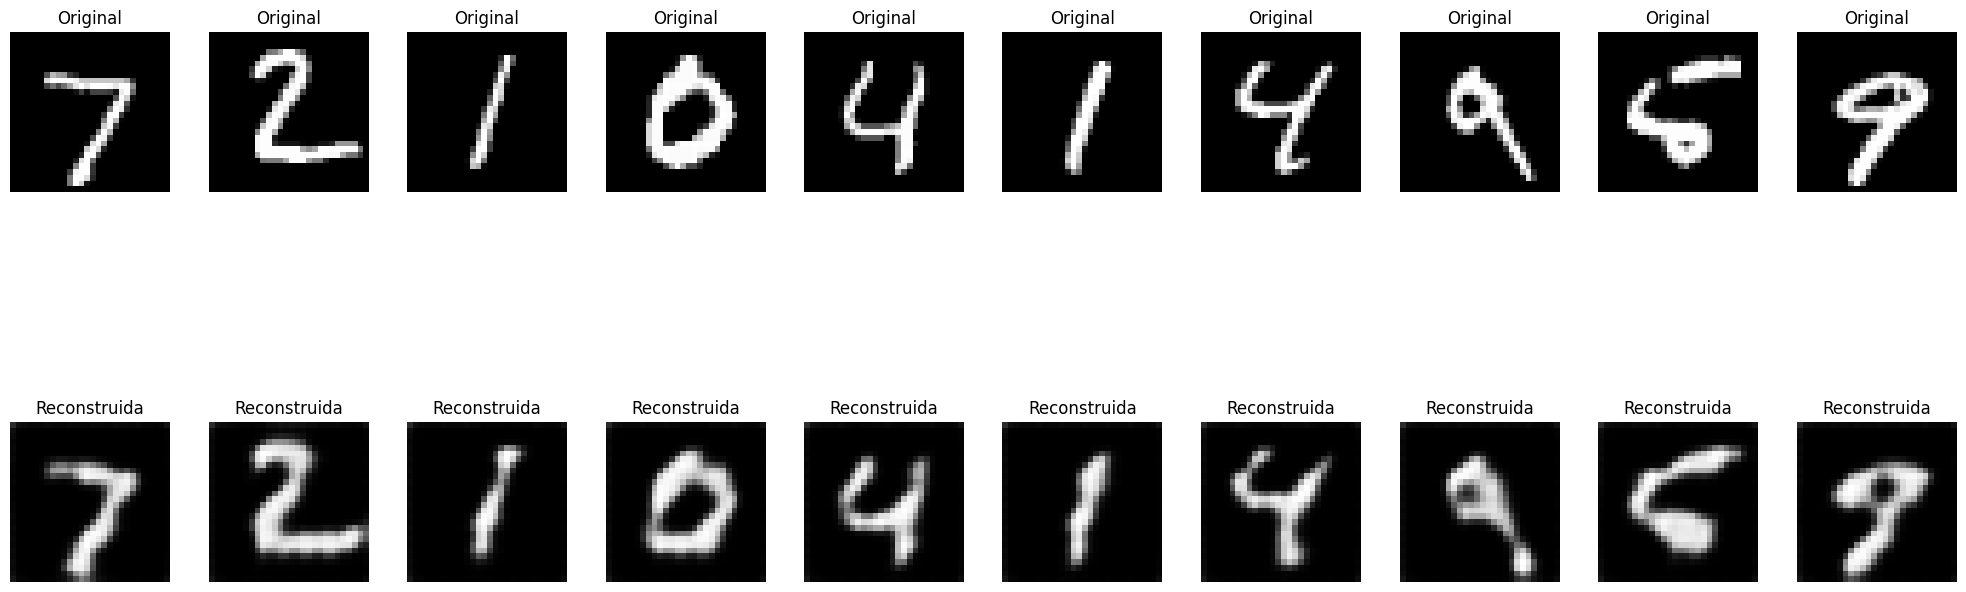

In [9]:
n = 10
example_images = mnist_digits_test[:n]
predictions = vqvae.vqvae.predict(example_images)

encondings = vqvae.encoder.predict(example_images)
vq_layer = vqvae.vqvae.get_layer("vector_quantizer")
quantized = vq_layer(encondings)
predictions = vqvae.decoder.predict(quantized)

plt.figure(figsize=(20, 6))
for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")
plt.tight_layout()
plt.show()

## FashionMNIST

In [3]:
(x_train, _), (x_test, _) = K.datasets.fashion_mnist.load_data()
fmnist_digits_train = tf.cast(x_train, tf.float64) / 255.0
fmnist_digits_train = np.expand_dims(fmnist_digits_train, -1)
fmnist_digits_test = tf.cast(x_test, tf.float64) / 255.0
fmnist_digits_test = np.expand_dims(fmnist_digits_test, -1)

fmnist_train_variance = np.var(x_train / 255.0) # Normalizar 

2025-09-28 11:36:16.463407: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-09-28 11:36:16.463463: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-09-28 11:36:16.463468: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
I0000 00:00:1759080976.463959 3571394 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1759080976.464270 3571394 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
f_vqvae = VQVAE(image_size=28, channels=1, latent_dim=128, train_variance=fmnist_train_variance, num_embeddings=128, beta=0.5)
f_vqvae.compile(optimizer=K.optimizers.Adam())
callbacks = f_vqvae.get_callbacks(log_dir="logs", patience=10)
f_vqvae.fit(fmnist_digits_train, epochs=50, batch_size=256, callbacks=callbacks)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 63.8743 - reconstruction_loss: 0.3898 - vqvae_loss: 63.4845
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 70.4132 - reconstruction_loss: 0.1965 - vqvae_loss: 70.2167
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 59.7005 - reconstruction_loss: 0.1640 - vqvae_loss: 59.5365
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 69.3760 - reconstruction_loss: 0.1543 - vqvae_loss: 69.2217
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 76.1141 - reconstruction_loss: 0.1449 - vqvae_loss: 75.9692
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 80.8370 - reconstruction_loss: 0.1364 - vqvae_loss: 80.7006
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 78.5319 - reconstruction_loss: 0.1293 - vqvae_loss: 78.4025
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 88.3548 - reconstruction_loss: 0.1250 - vqvae_loss: 88.2298
Epoch 9/50
235/235 ━━━━━━━━━━━━━

In [9]:
for metric in f_vqvae.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 111.50984954833984
reconstruction_loss: 0.11462724208831787
vq_loss: 111.39524841308594


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


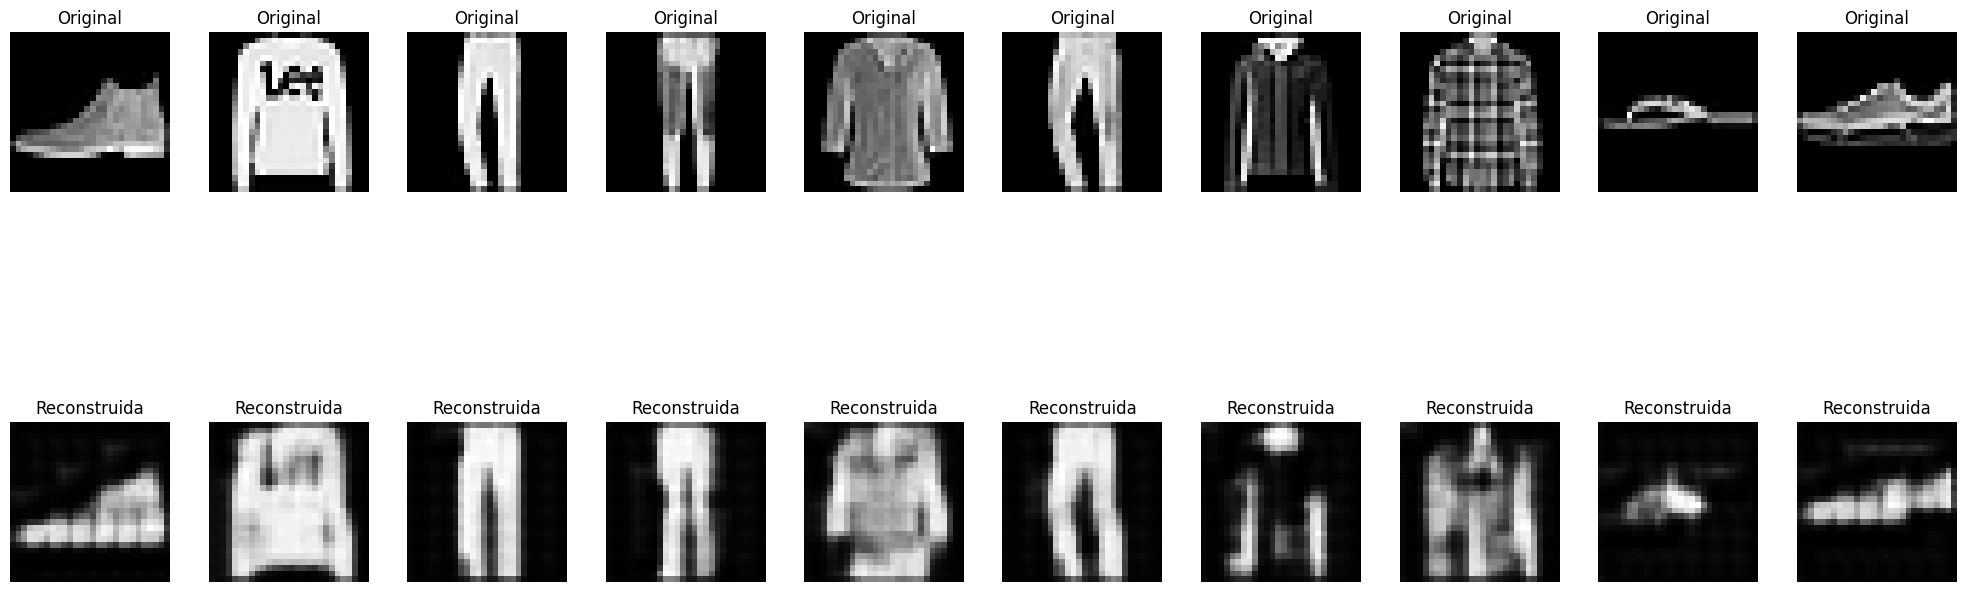

In [10]:
n = 10
example_images = fmnist_digits_test[:n]
predictions = f_vqvae.vqvae.predict(example_images)

encondings = f_vqvae.encoder.predict(example_images)
vq_layer = f_vqvae.vqvae.get_layer("vector_quantizer")
quantized = vq_layer(encondings)
predictions = f_vqvae.decoder.predict(quantized)

plt.figure(figsize=(20, 6))
for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")
plt.tight_layout()
plt.show()

## CelebA Dataset

In [4]:
# Import TFDS to download CelebA

import tensorflow_datasets as tfds

# Automatic download
#celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
#celeb_a_builder.download_and_prepare()

# If downloading manually
celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
celeb_a_builder.download_and_prepare(download_config=tfds.download.DownloadConfig(manual_dir="../datasets/"))

celeb_a_train = celeb_a_builder.as_dataset(split='train', shuffle_files=True)
celeb_a_test = celeb_a_builder.as_dataset(split='test', shuffle_files=True)

In [5]:
def preprocess_celeba(example):
    image = tf.cast(example['image'], tf.float32) / 255.0
    image = tf.image.resize(image, [64, 64])
    return image

batch_size = 256

celeb_a_train_batched = celeb_a_train.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
celeb_a_test_batched = celeb_a_test.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
all_train_images = celeb_a_train.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

sum_ = 0.0
sum_sq = 0.0
n = 0

for img in all_train_images:
    img = tf.cast(img, tf.float32)
    sum_ += tf.reduce_sum(img)
    sum_sq += tf.reduce_sum(tf.square(img))
    n += tf.size(img).numpy()

mean = sum_ / n
train_variance = (sum_sq / n) - (mean ** 2)
print("Varianza de entrenamiento CelebA:", train_variance.numpy())

2025-09-28 02:56:34.651727: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Varianza de entrenamiento CelebA: 0.08993451


2025-09-28 02:59:30.997838: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
train_variance = 0.08993451

vqvae2 = VQVAE(image_size=64, channels=3, latent_dim=256, train_variance=train_variance, num_embeddings=512, beta=0.25)

# Decoder adaptado para imágenes 64x64x3
latent_inputs = K.layers.Input(shape=vqvae2.encoder.output.shape[1:])
x = K.layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(latent_inputs)  # 16x16 -> 32x32
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)              # 32x32 -> 64x64
decoder_outputs = K.layers.Conv2DTranspose(vqvae2.channels, 3, padding="same", activation="sigmoid")(x)
custom_decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vqvae2 = VQVAE(image_size=64, channels=3, latent_dim=256, train_variance=train_variance, num_embeddings=256, beta=0.5, decoder=custom_decoder)
vqvae2.compile(optimizer=K.optimizers.Adam())

In [7]:
callbacks2 = vqvae2.get_callbacks(log_dir="logs", patience=10)
vqvae2.fit(celeb_a_train_batched, epochs=50, callbacks=callbacks2)

Epoch 1/50


2025-09-28 05:01:34.733581: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1759035694.843408    5029 service.cc:148] XLA service 0x72fb7c00e5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759035694.843449    5029 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2025-09-28 05:01:34.917951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759035695.140611    5029 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759035698.357653    5029 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


636/636 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - loss: 245.7294 - reconstruction_loss: 0.3710 - vqvae_loss: 245.3584
Epoch 2/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - loss: 136.9145 - reconstruction_loss: 0.2461 - vqvae_loss: 136.6684
Epoch 3/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 94.6148 - reconstruction_loss: 0.2112 - vqvae_loss: 94.4036
Epoch 4/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - loss: 136.5715 - reconstruction_loss: 0.2472 - vqvae_loss: 136.3242
Epoch 5/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - loss: 66.1487 - reconstruction_loss: 0.1996 - vqvae_loss: 65.9490
Epoch 6/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - loss: 54.1139 - reconstruction_loss: 0.1850 - vqvae_loss: 53.9288
Epoch 7/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - loss: 55.8100 - reconstruction_loss: 0.1787 - vqvae_loss: 55.6312
Epoch 8/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - loss: 60.1725 - reconstruction_loss: 0.1674 - vqvae_loss: 60.0051
Epoch 9/50
636/636 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


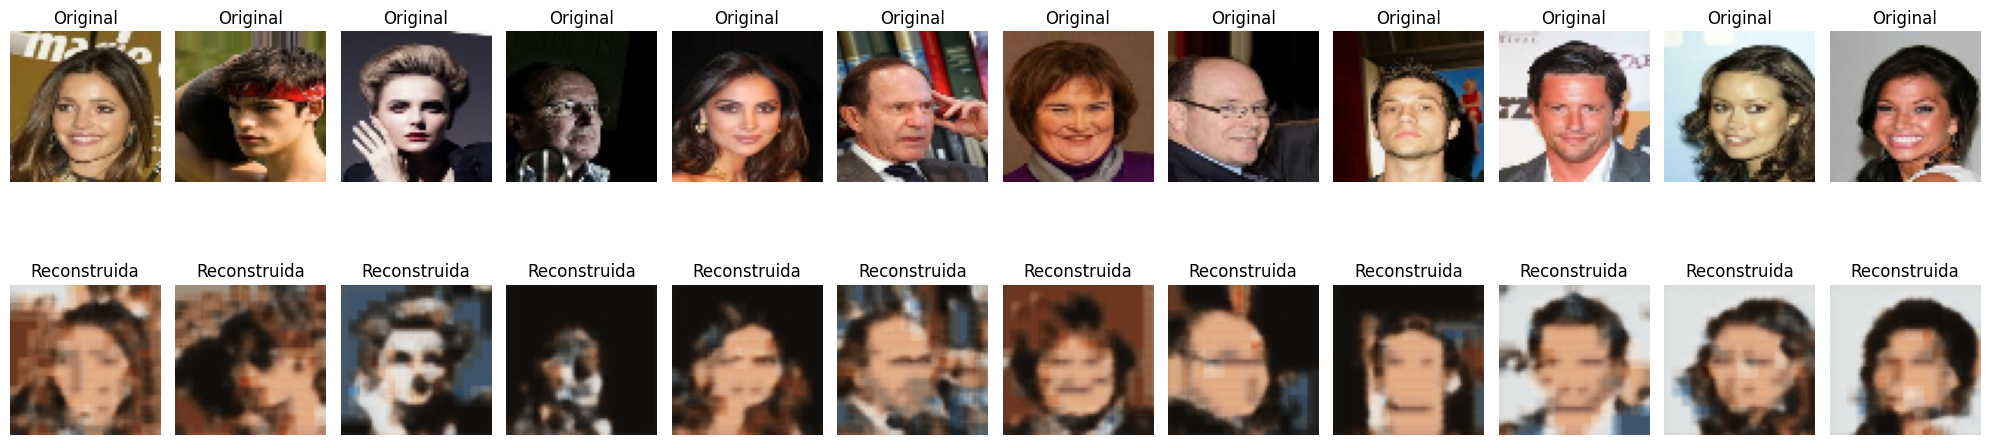

In [8]:
import matplotlib.pyplot as plt
import numpy as np

n = 12
images_list = []
for batch in celeb_a_test_batched:
    for img in batch:
        images_list.append(img.numpy())
        if len(images_list) == n:
            break
    if len(images_list) == n:
        break
images = np.stack(images_list)  # shape (n, 64, 64, 3)
predictions = vqvae2.vqvae.predict(images)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()

## CIFAR-10

In [38]:
(x_train, _), (x_test, _) = K.datasets.cifar10.load_data()
cifar_digits_train = tf.cast(x_train, tf.float64) / 255.0
cifar_digits_test = tf.cast(x_test, tf.float64) / 255.0

cifar_train_variance = np.var(x_train / 255.0) # Normalizar

In [ ]:
vqvae3 = VQVAE(image_size=32, channels=3, latent_dim=256, train_variance=cifar_train_variance, num_embeddings=512, beta=0.25)

# Decoder adaptado para imágenes 64x64x3
latent_inputs = K.layers.Input(shape=vqvae3.encoder.output.shape[1:])
x = K.layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(latent_inputs)  # 16x16 -> 32x32
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)              # 32x32 -> 64x64
decoder_outputs = K.layers.Conv2DTranspose(vqvae3.channels, 3, padding="same", activation="sigmoid")(x)
custom_decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vqvae3 = VQVAE(image_size=32, channels=3, latent_dim=256, train_variance=cifar_train_variance, num_embeddings=256, beta=0.5, decoder=custom_decoder)
vqvae3.compile(optimizer=K.optimizers.Adam())

callbacks = vqvae3.get_callbacks(log_dir="logs", patience=20)
vqvae3.fit(cifar_digits_train, epochs=100, batch_size=256, callbacks=callbacks)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 773.7396 - reconstruction_loss: 0.6933 - vqvae_loss: 773.0463
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 179.4439 - reconstruction_loss: 0.4127 - vqvae_loss: 179.0313
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 198.8125 - reconstruction_loss: 0.4123 - vqvae_loss: 198.4003
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 206.7222 - reconstruction_loss: 0.3881 - vqvae_loss: 206.3341
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 190.6490 - reconstruction_loss: 0.3854 - vqvae_loss: 190.2635
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - loss: 189.1183 - reconstruction_loss: 0.3789 - vqvae_loss: 188.7395
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - loss: 183.3564 - reconstruction_loss: 0.3661 - vqvae_loss: 182.9903
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 175.0098 - reconstruction_loss: 0.3523 - vqvae_loss: 174.6575
Epoch 9/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


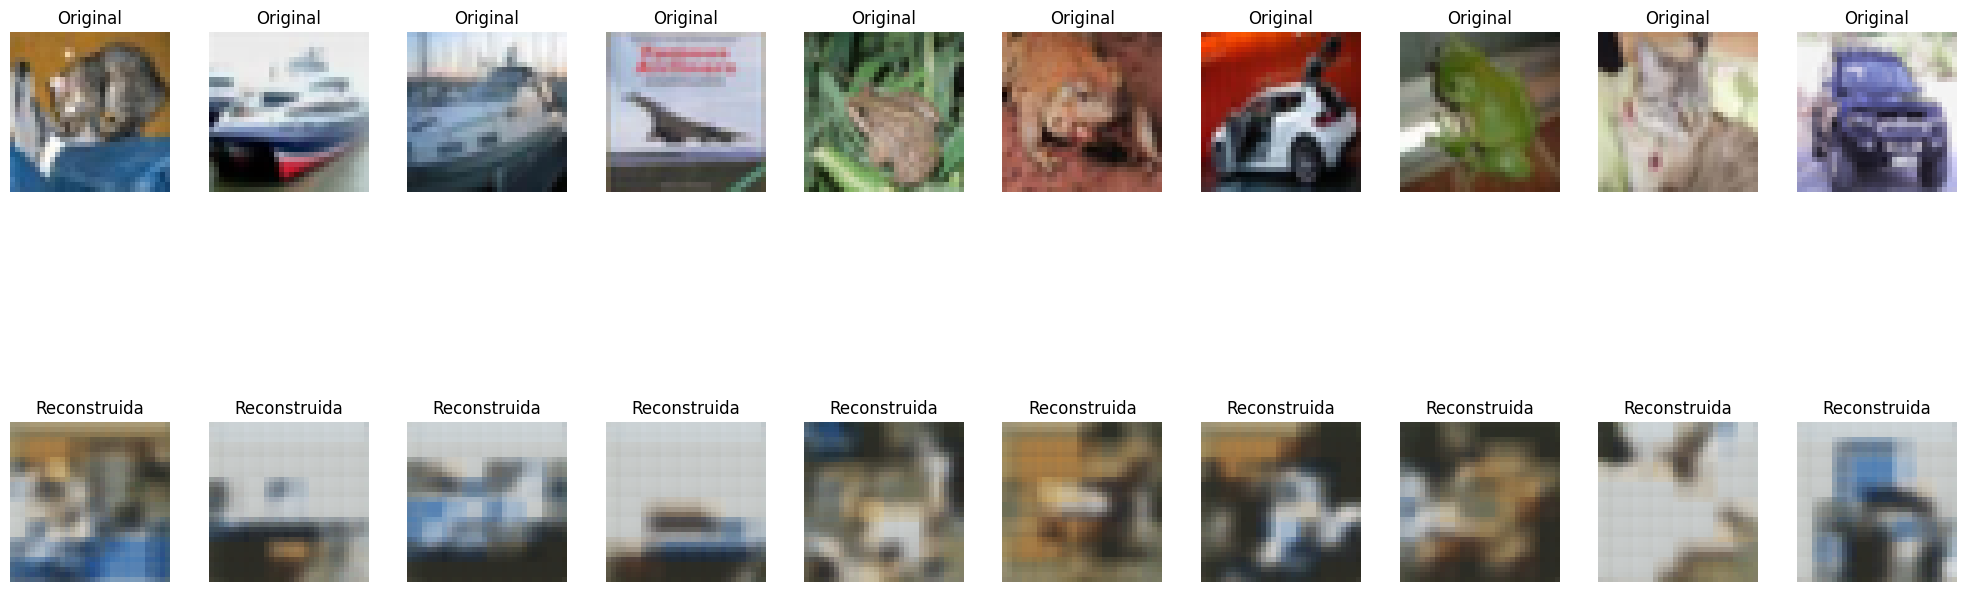

In [41]:
n = 10
example_images = cifar_digits_test[:n]
predictions = vqvae3.vqvae.predict(example_images)

plt.figure(figsize=(20, 6))
for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i])
    plt.title("Reconstruida")
    plt.axis("off")
plt.tight_layout()
plt.show()